## Motivation for doing Quantization Aware Training (QAT)

There's multiple purposes for quantizing your Neural Network to fewer bits than the conventional 32 bit:

* Less memory usage to fit a bigger model in a chip
* Quicker model inference

But the big issue of this is that at much smaller bits (around < 16 bits), the accuracy decays so badly that we simply can't just quantize a pre trained model and call it a day. This is where QAT comes in.

QAT is just a general term used for training pipelines that designed to train the model with the awareness .

A popular implementation is Straight Through Estimator (STE) which handles the backpropagation on quantized values, and brevitas uses STE by default.

But the beauty of brevitas is its modular, and it is allgedly designed so that you can plug in any estimator for backpropagation.

This makes brevitas an ideal package for research, where high transparency, controllablilty and flexibility is essential.

yt link of brevitass walkthrough: https://www.youtube.com/watch?v=wsXx3Hr5kZs

In [ ]:
"""
Author: Hyeon-Seo Yun 
Date: somewhere around Oct 25 2022
tutorial version of Brevitas_test
"""
# ! pip install -q kaggle
# ! pip install opendatasets
! pip install brevitas
! pip install hls4ml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 403 kB 4.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 295 kB 5.2 MB/s 
     |████████████████████████████████| 13.1 MB 48.5 MB/s 


## Data Collection

For the purpose of this tutorial, we will be using Higgs data from kaggle as our dataset.

In [ ]:
"""
This cell is for uploading your kaggle.json so you can download kaggle datasets
"""
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"seemsgood","key":"f3a664950e6ff6f23b20490722d64998"}'}

In [ ]:
"""
This cell is for moving your kaggle.json to the appropriate location
and then change the permissions of the file.
"""
! mkdir ~/.kaggle
! cp -f kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
"""
Download the higgs boson data
"""
! kaggle competitions download -c higgs-boson 
"""
unzip data to higgs-boson
"""
! unzip higgs-boson.zip -d higgs-boson

 76% 41.0M/54.3M [00:00<00:00, 151MB/s]
100% 54.3M/54.3M [00:00<00:00, 158MB/s]
Archive:  higgs-boson.zip
  inflating: higgs-boson/HiggsBosonCompetition_AMSMetric_rev1.py  
  inflating: higgs-boson/random_submission.zip  
  inflating: higgs-boson/test.zip    
  inflating: higgs-boson/training.zip  


In [ ]:
"""
unzip train datas (test here is not used)
"""
# ! unzip ./higgs-boson/test.zip -d ./higgs-boson/test/
! unzip ./higgs-boson/training.zip -d ./higgs-boson/training/

Archive:  ./higgs-boson/training.zip
  inflating: ./higgs-boson/training/training.csv  


## Data Preprocessing

In [ ]:
"""
Let's read the training csvs

"""
import pandas as pd
import numpy as np

df = pd.read_csv("./higgs-boson/training/training.csv")
# print(df.head()) # just printing what it looks like
df = df.drop(columns=['EventId', 'Weight']) # drop columns we don't use
"""
We filter out bad values
"""
df = df.replace(-999.000, np.nan)
df = df.dropna()
# print(df.head())
"""
We get rid of EventId column. Label column is our y (output). Rest is X (input)
"""
X = df.iloc[:, :-1].to_numpy()
Y = df.iloc[:, -1].to_numpy() # just get Label
# print(f"X shape: {X.shape}")
# print(f"Y shape: {Y.shape}")
# print(f"Y values b4: {Y}")
# turn the signal and background to 1 and 0 respectively
Y[Y == "s"] = 1
Y[Y == "b"] = 0
# print(np.any(Y == "s") or np.any(Y == "b")) # check if there's any non number left
# print(f"Y values after: {Y}")
Y = Y.astype('int32').reshape((-1,1))

In [ ]:
"""
pytorch data preprocessing
"""
import torch
X = torch.Tensor(X)
Y = torch.Tensor(Y)

"""
We do the train test split. We don't shuffle the data just yet, we can do that 
pytorch data loader
"""
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20)

"""
Now we gotta transfer the numpy data into a "dataset" so pytorch can load it as
as dataloader. This is not necessary, but a nice practice, since 
dataloaders shuffles data and you can change batch sizes easily
"""
from torch import Tensor
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
  def __init__(self, X: Tensor, labels: Tensor):
    self.X = X
    self.Y = labels
  def __len__(self):
      return self.X.shape[0]
  def __getitem__(self, idx: int):
    x = self.X[idx]
    label = self.Y[idx]
    return x, label

dataset_train = CustomDataset(X_train, Y_train)
train_dataloader = DataLoader(dataset_train, batch_size=64, shuffle=True)

##Brevitas

Brevitas uses Uniform Affine Quantization (UAQ) as its quantization method. This method takes:
* bit width
* scale factor
* zero point

Basic description of UAQ: You take float values into integer representation/ nearest integer representation. From then on, any operation as a quantized state, is done through these integer operations. The basic equation is shown below, where s = scale factor, z = zero point, and b = bit width


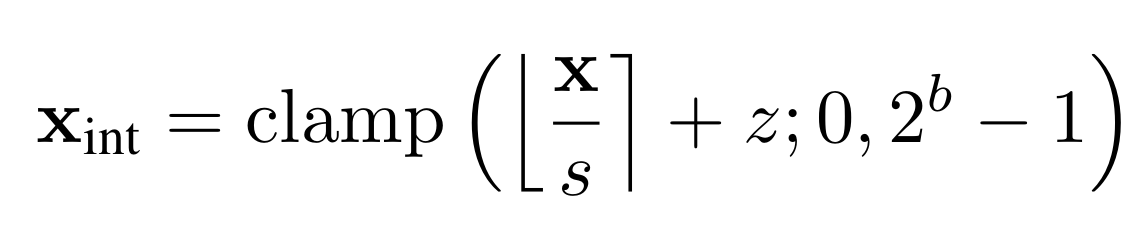


For more info on quantization, please read the white paper by QualComm: https://export.arxiv.org/pdf/2106.08295

In [ ]:
from brevitas.nn import QuantLinear
from brevitas.quant import Int8WeightPerTensorFixedPoint
import math


quant_linear = QuantLinear(2, 4, weight_quant=Int8WeightPerTensorFixedPoint, bias=False)

print(f"Quant Layer normal weight:\n{quant_linear.weight}")
print(f"Quant Layer quantized weight:\n{quant_linear.quant_weight()}")
print(f"Quant Layer quantized weight integer rep:\n{quant_linear.quant_weight().int()}")
print(f"Quant Weight fix point: {- math.log2(quant_linear.quant_weight().scale)}")
print(f"Quant Weight scale: {quant_linear.quant_weight().scale}")
print(f"Quant Weight bit width: {quant_linear.quant_weight().bit_width}")
print(f"Quant Weight zero point: {quant_linear.quant_weight().zero_point}")

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
Quant Layer normal weight:
Parameter containing:
tensor([[ 0.6935,  0.0371],
        [ 0.6587,  0.4903],
        [ 0.1031,  0.0078],
        [-0.0264, -0.0194]], requires_grad=True)
Quant Layer quantized weight:
QuantTensor(value=tensor([[ 0.6953,  0.0391],
        [ 0.6562,  0.4922],
        [ 0.1016,  0.0078],
        [-0.0234, -0.0156]], grad_fn=<MulBackward0>), scale=tensor(0.0078, grad_fn=<DivBackward0>), zero_point=tensor(0.), bit_width=tensor(8.), signed_t=tensor(True), training_t=tensor(True))
Quant Layer quantized weight integer rep:
tensor([[89,  5],
        [84, 63],
        [13,  1],
        [-3, -2]], dtype=torch.int32)
Quant Weight fix point: 7.0
Quant Weight scale: 0.0078125
Quant Weight bit width: 8.0
Quant Weight zero point: 0.0


Above we see an example of Quant Linear layer by brevitas. It has a normal set of weight and bias (optional) parameters. Next to it, it also has a set of quantized weights, scale and fixed point. We may also print directly these three parameters.

In [ ]:
"""
Below gives a good setup of the brevitas class and its default parameters
taken from the brevitas github page
https://github.com/Xilinx/brevitas
"""

import inspect
from brevitas.nn import QuantLinear, QuantReLU
from IPython.display import Markdown, display

def pretty_print_source(source):
    display(Markdown('```python\n' + source + '\n```'))
    
# source = inspect.getsource(QuantLinear.__init__)  
# pretty_print_source(source)
source = inspect.getsource(QuantReLU.__init__)  
pretty_print_source(source)

```python
    def __init__(
            self,
            act_quant: Optional[ActQuantType] = Uint8ActPerTensorFloat,
            input_quant: Optional[ActQuantType] = None,
            return_quant_tensor: bool = False,
            **kwargs):
        QuantNLAL.__init__(
            self,
            act_impl=nn.ReLU,
            passthrough_act=True,
            input_quant=input_quant,
            act_quant=act_quant,
            return_quant_tensor=return_quant_tensor,
            **kwargs)

```

## Making one's custom quantizers

Brevitas gives us the freedom to define our own quantizers for our own needs. 
By default, this is not the case, as these parameters are "automated" to fully unlock the potential of QAT. 

However, we have to ultimately port our model to hls4ml with its rigid ap_fixed (arbituary precision fixed) quantization standard. This means that we have to specifically freeze the scale factor, bit width and zero point to match our target ap_fixed parameter.

The code below allows us to do exactly that (code still in progress)

In [ ]:
from brevitas.core.function_wrapper.ops_ste import CeilSte
from brevitas.core.scaling import PowerOfTwoIntScaling
from brevitas.core.restrict_val import PowerOfTwoRestrictValue
from brevitas.quant.solver.weight import WeightQuantSolver
from brevitas.quant.solver.bias import BiasQuantSolver
from brevitas.quant.solver.act import ActQuantSolver
from brevitas.quant.base import *
from brevitas.inject import ExtendedInjector
from brevitas.inject.enum import ScalingImplType, StatsOp, RestrictValueType
from brevitas.core.scaling import ConstScaling

"""
NOTE: still not too sure if ScalingImplType.CONST is useful
"""

custom_bit_width = 8
custom_scale = 0.005
custom_scaling_impl = custom_scale*2**(custom_bit_width-1)
print(f"custom_scaling_impl: {custom_scaling_impl}")

class PerTensorActPoTScalingCustombit(ExtendedInjector):
    """
    """
    scaling_per_output_channel = False
    restrict_scaling_type = RestrictValueType.POWER_OF_TWO
    bit_width = custom_bit_width
    restrict_value_float_to_int_impl = CeilSte

class PerTensorWeightPoTScalingCustombit(ExtendedInjector):
    """
    """
    scaling_per_output_channel = False
    restrict_scaling_type = RestrictValueType.POWER_OF_TWO
    bit_width = custom_bit_width
    restrict_value_float_to_int_impl = CeilSte
    scaling_impl = ConstScaling(custom_scaling_impl)

class CustomMaxScaling(ExtendedInjector):
    """
    """
    scaling_impl_type = ScalingImplType.CONST
    scaling_stats_op = StatsOp.MAX

class ParamFromRuntimePercentileScaling(ExtendedInjector):
    """
    """
    scaling_impl_type = ScalingImplType.CONST
    scaling_stats_op = StatsOp.PERCENTILE
    percentile_q = 99.999
    collect_stats_steps = 300

class IntCustomWeightPerTensorFixedPoint(
    NarrowIntQuant, CustomMaxScaling, PerTensorWeightPoTScalingCustombit, WeightQuantSolver):
    """
    8-bit narrow per-tensor signed fixed-point weight quantizer with the radix point
    computed from backpropagated statistics of the weight tensor.

    Examples:
        >>> from brevitas.nn import QuantLinear
        >>> fc = QuantLinear(10, 5, bias=False, weight_quant=Int8WeightPerTensorFixedPoint)
        >>> fc.quant_weight()
    """
    pass


class IntCustomActPerTensorFixedPoint(
    IntQuant, ParamFromRuntimePercentileScaling, PerTensorActPoTScalingCustombit, ActQuantSolver):
    """
    8-bit per-tensor signed int activations fixed-point quantizer with learned radix point
    initialized from runtime statistics.

    Examples:
        >>> from brevitas.nn import QuantIdentity
        >>> act = QuantIdentity(act_quant=Int8ActPerTensorFixedPoint)
    """
    min_val = -custom_scale*(2**(custom_bit_width-1))
    max_val = custom_scale*(2**(custom_bit_width-1)-1)
    print(f"min_val: {min_val}")
    print(f"max_val: {max_val}")

# class UintCustomActPerTensorFixedPoint(
#     UintQuant, ParamFromRuntimePercentileScaling, PerTensorActPoTScalingCustombit, ActQuantSolver):
#     """
#     8-bit per-tensor unsigned int activations fixed-point quantizer with learned radix point
#     initialized from runtime statistics.

#     Examples:
#         >>> from brevitas.nn import QuantReLU
#         >>> act = QuantReLU(act_quant=Uint8ActPerTensorFixedPoint)
#     """
#     pass


class IntCustomBiasPerTensorFixedPointInternalScaling(
    IntQuant, MaxStatsScaling, PerTensorWeightPoTScalingCustombit, BiasQuantSolver):
    """
    8-bit per-tensor signed fixed-point bias quantizer with the radix point computed
    from backpropagated statistics of the bias tensor.

    Examples:
        >>> from brevitas.nn import QuantLinear
        >>> fc = QuantLinear(10, 5, bias=True, bias_quant=Int8BiasPerTensorFixedPointInternalScaling)
    """
    requires_input_scale = False
    requires_input_bit_width = False


custom_scaling_impl: 0.64
min_val: -0.64
max_val: 0.635


In [ ]:
from brevitas.nn import QuantIdentity
"""
Seems like scale 
"""
min_val = -custom_scale*(2**(custom_bit_width-1))
max_val = custom_scale*(2**(custom_bit_width-1)-1)
float_input = torch.randn(3, 2)
float_input[0][0] = 0.75
# float_input[0][1] = min_val - 1
float_input[1][0] =  0.75 -0.001
print(float_input[0])
quant_identity = QuantIdentity(act_quant=IntCustomActPerTensorFixedPoint, return_quant_tensor=True)
quant_input = quant_identity(float_input)

print(f"Float input:\n {float_input} \n")
print(f"Quant input:\n {quant_input} \n")

float_bias = torch.zeros(3)
# float_bias[0] = 0.75
# float_bias[1] = 0.75 -0.001
# float_bias[2] = 5
quant_bias = quant_identity(float_bias)

print(f"Float bias:\n {float_bias} \n")
print(f"Quant bias:\n {quant_bias} \n")

tensor([0.7500, 1.8089])
Float input:
 tensor([[ 0.7500,  1.8089],
        [ 0.7490, -2.0601],
        [ 0.1172, -0.9424]]) 

Quant input:
 QuantTensor(value=tensor([[ 0.7500,  0.9922],
        [ 0.7500, -1.0000],
        [ 0.1172, -0.9453]]), scale=tensor(0.0078), zero_point=tensor(0.), bit_width=tensor(8.), signed_t=tensor(True), training_t=tensor(True)) 

Float bias:
 tensor([0., 0., 0.]) 

Quant bias:
 QuantTensor(value=tensor([0., 0., 0.]), scale=tensor(0.0078), zero_point=tensor(0.), bit_width=tensor(8.), signed_t=tensor(True), training_t=tensor(True)) 



In [ ]:
import torch.nn as nn
normal_linear = nn.Linear(2, 3, bias = True)
normal_linear.weight = nn.Parameter(float_input)
normal_linear.bias = nn.Parameter(float_bias)


In [ ]:
BREVITAS_IGNORE_MISSING_KEYS = True
quant_linear = QuantLinear(
    2, 3,
    weight_quant=IntCustomWeightPerTensorFixedPoint, 
    bias=True, bias_quant=IntCustomBiasPerTensorFixedPointInternalScaling
    )
quant_linear.load_state_dict(normal_linear.state_dict())


print(f"Weight QuantTensor:\n {quant_linear.quant_weight()}")
# print(f"Weight fix point: {- math.log2(quant_linear.quant_weight().scale)}")
print(f"Weight scale: {quant_linear.quant_weight().scale}")
# print(f"Weight fix point: {quant_linear.quant_weight().scale.int()}")

print(f"Bias QuantTensor:\n {quant_linear.quant_bias()}")
print(f"Bias scale: {quant_linear.quant_bias().scale}")

Weight QuantTensor:
 QuantTensor(value=tensor([[ 0.6350,  0.6350],
        [ 0.6350, -0.6350],
        [ 0.1150, -0.6350]], grad_fn=<MulBackward0>), scale=tensor(0.0050), zero_point=tensor(0.), bit_width=tensor(8.), signed_t=tensor(True), training_t=tensor(True))
Weight scale: 0.004999999888241291
Bias QuantTensor:
 QuantTensor(value=tensor([0., 0., 0.], grad_fn=<MulBackward0>), scale=tensor(0.0050), zero_point=tensor(0.), bit_width=tensor(8.), signed_t=tensor(True), training_t=tensor(True))
Bias scale: 0.004999999888241291


Here, we now test ap_fixed precision, so that we could come up with an accurate conversion function from ap_fixed to UAQ.

In [ ]:
"""
ap_fixed hls4ml testing
"""
import hls4ml 
from sklearn.metrics import mean_squared_error


int_bit = 2
fract_bit = 2
total_bit = int_bit + fract_bit
ap_fixed_config = f"ap_fixed<{total_bit},{int_bit}>"
normal_linear = nn.Sequential(normal_linear)
config = hls4ml.utils.config_from_pytorch_model(normal_linear,
                                    default_precision=ap_fixed_config,
                                    granularity='model'
)
print(f"config: {config}")
hls_linear = hls4ml.converters.convert_from_pytorch_model(normal_linear,
                                                    hls_config=config,
                                                    output_dir='model_1/hls4ml_prj',
                                                    part='xcu250-figd2104-2L-e',
                                                    input_shape = (100,2) # 100 here is irrelevant
)
hls_linear.compile()


config: {'Model': {'Precision': 'ap_fixed<4,2>', 'ReuseFactor': 1, 'Strategy': 'Latency'}}
Interpreting Model ...
Topology:
Input Shape:  [[100, 2]]
Layer name: 0, layer type: Dense, input shape: [[100, 2]]
Creating HLS model
Writing HLS project
Done


In [ ]:
hls_input = np.ascontiguousarray(np.array([[1.0,0.0]]))
torch_input = torch.from_numpy(hls_input).float()
print(hls_linear.predict(hls_input))
print(normal_linear(torch_input))

[0.75 0.75 0.  ]
tensor([[0.7500, 0.7490, 0.1172]], grad_fn=<AddmmBackward0>)


In [ ]:
"""
conversion function from target ap_fixed to parameters for UAQ
"""
from typing import Tuple

def ConvAp_FixedToUAQ(int_bitwidth, fract_bitwidth) -> Tuple[int,float,float]:
  """
  parameters:
  int_bitwidth: int 
  fract_bitwidth: int

  return:
  bitwidth: int
  scale_factor: float
  zero_point: float
  """
  bitwidth = int_bitwidth + fract_bitwidth
  scale_factor = 2**(-fract_bitwidth)
  zero_point = 0 # we assume int representation is signed
  
  return (bitwidth, scale_factor, zero_point)

In [ ]:
target_int_bitwidth = 4
target_fract_bitwidth = 5

target_bitwidth, target_scale_factor, target_zero_point = ConvAp_FixedToUAQ(target_int_bitwidth, target_fract_bitwidth)

In [ ]:
print(target_bitwidth, target_scale_factor, target_zero_point)

9 0.03125 0


In [ ]:
"""
Reinitialize the custom quantizers for a realistic stuff
testing
"""

custom_bit_width = target_bitwidth
custom_scale = target_scale_factor
custom_scaling_impl = custom_scale*2**(custom_bit_width-1)

class PerTensorActPoTScalingCustombit(ExtendedInjector):
    """
    """
    scaling_per_output_channel = False
    restrict_scaling_type = RestrictValueType.POWER_OF_TWO
    bit_width = custom_bit_width
    restrict_value_float_to_int_impl = CeilSte

class PerTensorWeightPoTScalingCustombit(ExtendedInjector):
    """
    """
    scaling_per_output_channel = False
    restrict_scaling_type = RestrictValueType.POWER_OF_TWO
    bit_width = custom_bit_width
    restrict_value_float_to_int_impl = CeilSte
    scaling_impl = ConstScaling(custom_scaling_impl)

class CustomMaxScaling(ExtendedInjector):
    """
    """
    scaling_impl_type = ScalingImplType.CONST
    scaling_stats_op = StatsOp.MAX

class ParamFromRuntimePercentileScaling(ExtendedInjector):
    """
    """
    scaling_impl_type = ScalingImplType.CONST
    scaling_stats_op = StatsOp.PERCENTILE
    percentile_q = 99.999
    collect_stats_steps = 300

class IntCustomWeightPerTensorFixedPoint(
    NarrowIntQuant, CustomMaxScaling, PerTensorWeightPoTScalingCustombit, WeightQuantSolver):
    """
    8-bit narrow per-tensor signed fixed-point weight quantizer with the radix point
    computed from backpropagated statistics of the weight tensor.

    Examples:
        >>> from brevitas.nn import QuantLinear
        >>> fc = QuantLinear(10, 5, bias=False, weight_quant=Int8WeightPerTensorFixedPoint)
        >>> fc.quant_weight()
    """
    pass


class IntCustomActPerTensorFixedPoint(
    IntQuant, ParamFromRuntimePercentileScaling, PerTensorActPoTScalingCustombit, ActQuantSolver):
    """
    8-bit per-tensor signed int activations fixed-point quantizer with learned radix point
    initialized from runtime statistics.

    Examples:
        >>> from brevitas.nn import QuantIdentity
        >>> act = QuantIdentity(act_quant=Int8ActPerTensorFixedPoint)
    """
    min_val = -custom_scale*2**(custom_bit_width-1)
    max_val = custom_scale*(2**(custom_bit_width-1)-1)
    print(f"min_val: {min_val}")
    print(f"max_val: {max_val}")

# class UintCustomActPerTensorFixedPoint(
#     UintQuant, ParamFromRuntimePercentileScaling, PerTensorActPoTScalingCustombit, ActQuantSolver):
#     """
#     8-bit per-tensor unsigned int activations fixed-point quantizer with learned radix point
#     initialized from runtime statistics.

#     Examples:
#         >>> from brevitas.nn import QuantReLU
#         >>> act = QuantReLU(act_quant=Uint8ActPerTensorFixedPoint)
#     """
#     pass


class IntCustomBiasPerTensorFixedPointInternalScaling(
    IntQuant, MaxStatsScaling, PerTensorWeightPoTScalingCustombit, BiasQuantSolver):
    """
    8-bit per-tensor signed fixed-point bias quantizer with the radix point computed
    from backpropagated statistics of the bias tensor.

    Examples:
        >>> from brevitas.nn import QuantLinear
        >>> fc = QuantLinear(10, 5, bias=True, bias_quant=Int8BiasPerTensorFixedPointInternalScaling)
    """
    requires_input_scale = False
    requires_input_bit_width = False

min_val: -8.0
max_val: 7.96875


In [ ]:
from brevitas.nn import QuantIdentity
"""
testing
"""
min_val = -custom_scale*(2**(custom_bit_width-1))
max_val = custom_scale*(2**(custom_bit_width-1)-1)
float_input = torch.randn(3, 2)
float_input[0][0] = 0.75
# float_input[0][1] = min_val - 1
float_input[1][0] =  0.75 -0.001
print(float_input[0])
quant_identity = QuantIdentity(act_quant=IntCustomActPerTensorFixedPoint, return_quant_tensor=True)
quant_input = quant_identity(float_input)

print(f"Float input:\n {float_input} \n")
print(f"Quant input:\n {quant_input} \n")

float_bias = torch.zeros(3)
# float_bias[0] = 0.75
# float_bias[1] = 0.75 -0.001
# float_bias[2] = 5
quant_bias = quant_identity(float_bias)

print(f"Float bias:\n {float_bias} \n")
print(f"Quant bias:\n {quant_bias} \n")

tensor([0.7500, 1.0678])
Float input:
 tensor([[ 0.7500,  1.0678],
        [ 0.7490, -0.4753],
        [ 1.2279, -0.3656]]) 

Quant input:
 QuantTensor(value=tensor([[ 0.7500,  1.0625],
        [ 0.7500, -0.4688],
        [ 1.2188, -0.3750]]), scale=tensor(0.0312), zero_point=tensor(0.), bit_width=tensor(9.), signed_t=tensor(True), training_t=tensor(True)) 

Float bias:
 tensor([0., 0., 0.]) 

Quant bias:
 QuantTensor(value=tensor([0., 0., 0.]), scale=tensor(0.0312), zero_point=tensor(0.), bit_width=tensor(9.), signed_t=tensor(True), training_t=tensor(True)) 



Now let's validate that our conversion is spot on with some quick tests:

In [ ]:
import brevitas.nn as qnn
from brevitas.core.quant import QuantType
from brevitas.quant.scaled_int import Int8ActPerTensorFloat, Int8WeightPerTensorFloat
from brevitas.quant.shifted_scaled_int import ShiftedUint8ActPerTensorFloat
import brevitas.quant.fixed_point as fp
"""
NOTE: try quantizing the input data and 
see if there's big changes
"""

input_dim = 30
# mlp_dims = [30 , 64, 32, 32]
mlp_dims = [30 , 16, 8, 8]
# mlp_dims = [30 , 128, 64, 64]
mlp_blocks = [nn.BatchNorm1d(input_dim)]
for idx in range(len(mlp_dims)-1):
  # print(mlp_dims[idx + 1])
  mlp_blocks.append(qnn.QuantLinear(
                  int(mlp_dims[idx]), 
                  int(mlp_dims[idx + 1]),
                  bias=True,
                  weight_quant=IntCustomWeightPerTensorFixedPoint,
                  bias_quant=IntCustomBiasPerTensorFixedPointInternalScaling,
                  input_quant= IntCustomActPerTensorFixedPoint,
                  output_quant= IntCustomActPerTensorFixedPoint,
                  return_quant_tensor=True
                  )  
  )
  
  mlp_blocks.append(
      qnn.QuantReLU(
          act_quant=IntCustomActPerTensorFixedPoint,
          return_quant_tensor=True
      )
  )
# add last layer
mlp_blocks.append(qnn.QuantLinear(
                  mlp_dims[len(mlp_dims)-1], 
                  1,
                  bias=True,
                  weight_quant=IntCustomWeightPerTensorFixedPoint,
                  bias_quant=IntCustomBiasPerTensorFixedPointInternalScaling,
                  input_quant= IntCustomActPerTensorFixedPoint,
                  output_quant= IntCustomActPerTensorFixedPoint,
                  return_quant_tensor=True
                  )
)
mlp_blocks.append(
      qnn.QuantSigmoid(
          act_quant=IntCustomActPerTensorFixedPoint,
          return_quant_tensor=True
      )
)
model_bv_seq = nn.Sequential(*mlp_blocks)


In [ ]:
"""
Training phase
"""
import torch.nn.functional as F

model_bv_seq.train() # put model in train mode (for batchnormalization)
optimizer = torch.optim.AdamW(model_bv_seq.parameters(), lr=1e-3)
i = 0
for x, y in train_dataloader:
  # print(y.shape)
  # print(model_bv_seq(x).shape)
  loss = F.binary_cross_entropy(model_bv_seq(x), y)
  i +=1
  # if i > 100:
  #   break

  optimizer.zero_grad() # this deletes all previous grad calculations. very important
  loss.backward() # calculates the gradients
  optimizer.step() # applies backpropagation

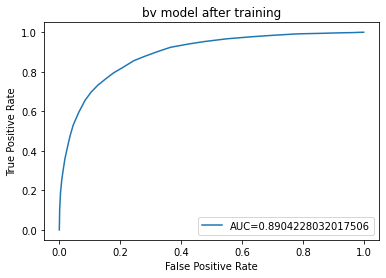

In [ ]:
"""
Testing phase
"""
from sklearn import metrics
import matplotlib.pyplot as plt

model_bv_seq.eval() # put model in eval mode 
with torch.no_grad():
  Y_hat = model_bv_seq(X_test)[0]
  fpr, tpr, _ = metrics.roc_curve(Y_test,  Y_hat)
  auc = metrics.roc_auc_score(Y_test, Y_hat)
  

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("bv model after training")
plt.legend(loc=4)
plt.show()

In [ ]:
# print(len(model_bv_seq.mlp))
# print((model_bv_seq.mlp))
N_test = X_test.shape[0]
sample_size = 10
bins = 500
sample_idxs = np.random.choice(N_test, sample_size)
# print(X_test.shape)

quantlinear layer tensor bit_width: 9.0


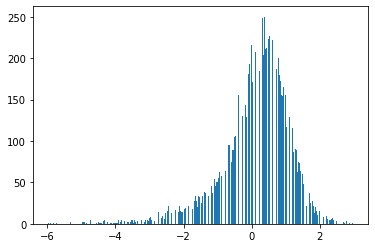

hidden activation layer tensor bit_width: 9.0


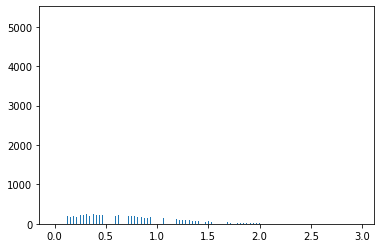

quantlinear layer tensor bit_width: 9.0


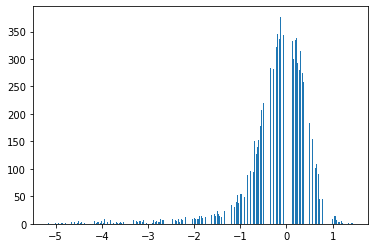

hidden activation layer tensor bit_width: 9.0


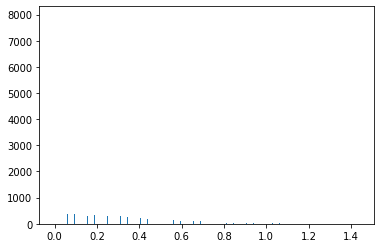

quantlinear layer tensor bit_width: 9.0


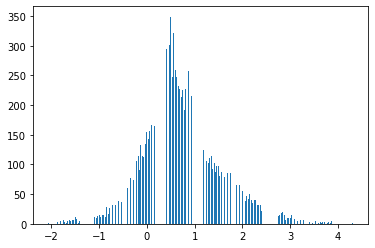

hidden activation layer tensor bit_width: 9.0


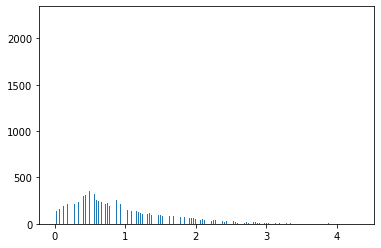

output quantlinear layer tensor bit_width: 9.0


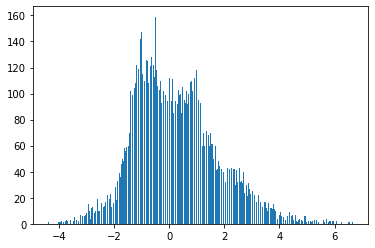

QuantSigmoid activation
QuantSigmoid output: torch.Size([13623, 1])


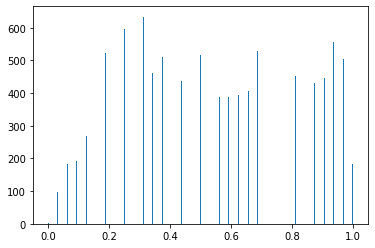

In [ ]:
"""
plot histograms
"""
from sklearn import metrics
import matplotlib.pyplot as plt


model_bv_seq.eval() # put model in eval mode (for batchnormalization)
with torch.no_grad():
  # y_hat = model_bv_seq[0](X_test[sample_idxs])
  y_hat = model_bv_seq[0](X_test) # batchnorm

  for idx in range(1,len(model_bv_seq)-2):
    # print(f"idx: {idx}")
    y_hat = model_bv_seq[idx](y_hat)
    if idx%2 ==1: # quantlinear
      print(f"quantlinear layer tensor bit_width: {y_hat.bit_width}")
    else:# activation
      print(f"hidden activation layer tensor bit_width: {y_hat.bit_width}")
    
    plt.hist(y_hat[0][:,0], bins= bins)
    plt.show()

  idx = len(model_bv_seq)-2
  y_hat = model_bv_seq[idx](y_hat)
  print(f"output quantlinear layer tensor bit_width: {y_hat.bit_width}")
  plt.hist(y_hat[0][:,0], bins= bins)
  plt.show()
  idx = len(model_bv_seq)-1
  y_hat = model_bv_seq[idx](y_hat)
  # print(f"output activation layer tensor : {y_hat}")
  # print("Sigmoid activation")
  # plt.hist(y_hat.flatten(), bins= bins)

  print("QuantSigmoid activation")
  print(f"QuantSigmoid output: {y_hat[0].shape}")
  plt.hist(y_hat[0].flatten(), bins= bins)

  plt.show()

    
  



In [ ]:
"""
IMPORTANT
save the model to layer load it in a normal sequential for hls4ml
"""
save_path = "./model.pt"
torch.save(model_bv_seq.state_dict(), save_path)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1366: UserWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  "Positional args are being deprecated, use kwargs instead. Refer to "


In [ ]:
# print(model_bv_seq)

In [ ]:
"""
define and initialize the torch model for hls4ml conversion.
Pls note that nn.Sigmoid() is commented out as that is not supported by hls4ml
"""
import copy
from collections import OrderedDict

input_dim = 30
weight_precision = 8 # 8
# mlp_dims = [30 , 64, 32, 32]
mlp_dims = [30 , 16, 8, 8]
mlp_blocks = [nn.BatchNorm1d(input_dim)]
# mlp_blocks = []
for idx in range(len(mlp_dims)-1):
  # print(mlp_dims[idx + 1])
  mlp_blocks.append(nn.Linear(
                  int(mlp_dims[idx]), 
                  int(mlp_dims[idx + 1]),
                  bias=True
                  )
                  
  )
  mlp_blocks.append(
      nn.ReLU()
  )
# add last layer
mlp_blocks.append(nn.Linear(
                  mlp_dims[len(mlp_dims)-1], 
                  1,
                  bias=True,
                  )
  )
# mlp_blocks.append(nn.Sigmoid())
torch_model = nn.Sequential(*mlp_blocks)
print(f"torch model: {torch_model}")

state_dict = torch.load(save_path)
state_dict_copy = copy.deepcopy(state_dict)
for key, value in state_dict.items():
  # print(f"key: {key}")

  if "quant" in key:
    # print(f"key: {key}")
    del state_dict_copy[key]
# print(f"new state dict without quantization keys: {state_dict_copy}")
torch_model.load_state_dict(state_dict_copy)

# state_dict_copy_copy = OrderedDict()

# for key, value in state_dict_copy.items():
#   idx = int(key[0])-1
#   new_key =  str(idx) + key[1:]
#   print(f"new_key: {new_key}")
#   state_dict_copy_copy[new_key] = value

# torch_model.load_state_dict(state_dict_copy_copy)
print(f"torch model: {torch_model}")

torch model: Sequential(
  (0): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Linear(in_features=30, out_features=16, bias=True)
  (2): ReLU()
  (3): Linear(in_features=16, out_features=8, bias=True)
  (4): ReLU()
  (5): Linear(in_features=8, out_features=8, bias=True)
  (6): ReLU()
  (7): Linear(in_features=8, out_features=1, bias=True)
)
torch model: Sequential(
  (0): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Linear(in_features=30, out_features=16, bias=True)
  (2): ReLU()
  (3): Linear(in_features=16, out_features=8, bias=True)
  (4): ReLU()
  (5): Linear(in_features=8, out_features=8, bias=True)
  (6): ReLU()
  (7): Linear(in_features=8, out_features=1, bias=True)
)


cut_down_model: Sequential(
  (1): Linear(in_features=30, out_features=16, bias=True)
  (2): ReLU()
  (3): Linear(in_features=16, out_features=8, bias=True)
  (4): ReLU()
  (5): Linear(in_features=8, out_features=8, bias=True)
  (6): ReLU()
  (7): Linear(in_features=8, out_features=1, bias=True)
)
config: {'Model': {'Precision': 'ap_fixed<9,4>', 'ReuseFactor': 1, 'Strategy': 'Latency'}}
Interpreting Model ...
Topology:
Input Shape:  [[100, 30]]
Layer name: 1, layer type: Dense, input shape: [[100, 30]]
Layer name: 2, layer type: Activation, input shape: [[100, 16]]
Layer name: 3, layer type: Dense, input shape: [[100, 16]]
Layer name: 4, layer type: Activation, input shape: [[100, 8]]
Layer name: 5, layer type: Dense, input shape: [[100, 8]]
Layer name: 6, layer type: Activation, input shape: [[100, 8]]
Layer name: 7, layer type: Dense, input shape: [[100, 8]]
Creating HLS model
Writing HLS project
Done
X_test b4: torch.Size([13623, 30])
norm_out after: torch.Size([13623, 30])
MSE bv v

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:295.)


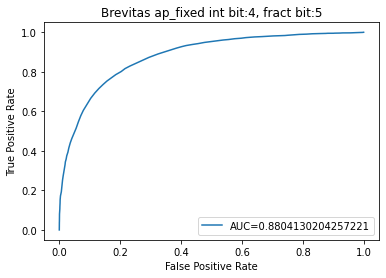

In [ ]:
"""
check if torch hls conversion is good
"""
import hls4ml 
from sklearn.metrics import mean_squared_error


int_bit = target_int_bitwidth 
fract_bit = target_fract_bitwidth
total_bit = int_bit + fract_bit
ap_fixed_config = f"ap_fixed<{total_bit},{int_bit}>"
print(f"cut_down_model: {torch_model[1:]}")
config = hls4ml.utils.config_from_pytorch_model(
                                    torch_model[1:],
                                    default_precision=ap_fixed_config,
                                    granularity='model'
)
print(f"config: {config}")
hls_model = hls4ml.converters.convert_from_pytorch_model(
                                                    torch_model[1:],
                                                    hls_config=config,
                                                    output_dir='model_1/hls4ml_prj',
                                                    part='xcu250-figd2104-2L-e',
                                                    input_shape = (100,30) # 100 here is irrelevant
)
hls_model.compile()
torch_model.eval()
with torch.no_grad():
  print(f"X_test b4: {X_test.shape}")
  batchnorm = torch_model[0]
  norm_out = batchnorm(X_test)
  print(f"norm_out after: {norm_out.shape}")
  X_hls_test = np.ascontiguousarray(norm_out)
  Y_hat_hls = torch.sigmoid(torch.from_numpy(hls_model.predict(X_hls_test)))

torch_model.eval()
model_bv_seq.eval()
with torch.no_grad():
  Y_hat_bv = torch.sigmoid(model_bv_seq(X_test))
  Y_hat_torch = torch.sigmoid(torch_model(X_test))
MSE = mean_squared_error(Y_hat_bv.cpu().numpy(), Y_hat_hls.cpu().numpy())
print(f"MSE bv vs hls test output: {MSE}")
MSE = mean_squared_error(Y_hat_torch.cpu().numpy(), Y_hat_hls.cpu().numpy())
print(f"MSE loaded torch model vs hls test output: {MSE}")

fpr, tpr, _ = metrics.roc_curve(Y_test,  Y_hat_hls.cpu().numpy())
auc = metrics.roc_auc_score(Y_test, Y_hat_hls.cpu().numpy())
  

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
# plt.title("torch model from trained bv model parameters")
plt.title(f"Brevitas ap_fixed int bit:{int_bit}, fract bit:{fract_bit}")
plt.legend(loc=4)
plt.show()

From MSE values, bv model and torch model's predictions are not very close.
This makes sense as torch model doesn't have quantized activations.

However, hls4ml model and torch model's predictions are very close, despite low ap_fixed values.


This difference is shown with a lower performance for hls model compared to bv model (difference of 0.02 AUC).

However, this is small enough where it could be attributed to hls4ml sw simulation error, and may not be an accurate prediction of real life fpga performance. Moreover, the data we are using is dummy data.

In [ ]:
"""
Let's just quickly compare the non bv model quantization with hls4ml
"""

input_dim = 30
mlp_blocks = [nn.BatchNorm1d(input_dim)]
for idx in range(len(mlp_dims)-1):
  # print(mlp_dims[idx + 1])
  mlp_blocks.append(nn.Linear(
                  int(mlp_dims[idx]), 
                  int(mlp_dims[idx + 1]),
                  bias=True
                  )
                  
  )
  mlp_blocks.append(
      nn.ReLU()
  )
# add last layer
mlp_blocks.append(nn.Linear(
                  mlp_dims[len(mlp_dims)-1], 
                  1,
                  bias=True,
                  )
  )


normal_model = nn.Sequential(*mlp_blocks)

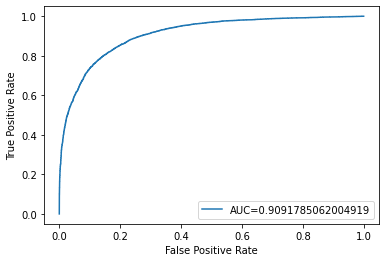

In [ ]:
"""
Training phase and testing
NOTE: no sigmoid in the model itself
"""
import torch.nn.functional as F

normal_model.train() # put model in train mode (for batchnormalization)
optimizer = torch.optim.AdamW(normal_model.parameters(), lr=1e-3)
i = 0
for x, y in train_dataloader:
  # print(y.shape)
  # print(normal_model(x).shape)
  logit = normal_model(x)
  loss = F.binary_cross_entropy(torch.sigmoid(logit), y)
  i +=1
  # if i > 100:
  #   break

  optimizer.zero_grad() # this deletes all previous grad calculations. very important
  loss.backward() # calculates the gradients
  optimizer.step() # applies backpropagation
  


normal_model.eval() # put model in eval mode 
with torch.no_grad():
  logit = normal_model(X_test)
  fpr, tpr, _ = metrics.roc_curve(Y_test,  torch.sigmoid(logit))
  auc = metrics.roc_auc_score(Y_test, torch.sigmoid(logit))
  

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

config: {'Model': {'Precision': 'ap_fixed<9,4>', 'ReuseFactor': 1, 'Strategy': 'Latency'}}
Interpreting Model ...
Topology:
Input Shape:  [[100, 30]]
Layer name: 0, layer type: BatchNormalization, input shape: [[100, 30]]
Layer name: 1, layer type: Dense, input shape: [[100, 30]]
Layer name: 2, layer type: Activation, input shape: [[100, 16]]
Layer name: 3, layer type: Dense, input shape: [[100, 16]]
Layer name: 4, layer type: Activation, input shape: [[100, 8]]
Layer name: 5, layer type: Dense, input shape: [[100, 8]]
Layer name: 6, layer type: Activation, input shape: [[100, 8]]
Layer name: 7, layer type: Dense, input shape: [[100, 8]]
Creating HLS model
Writing HLS project
Done
MSE torch vs hls test output: 0.3481791317462921


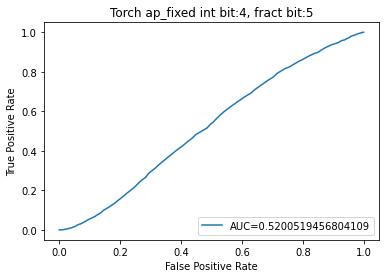

In [ ]:
"""
now plot the ROC with same quantization
"""
ap_fixed_config = f"ap_fixed<{total_bit},{int_bit}>"
config = hls4ml.utils.config_from_pytorch_model(normal_model,
                                    default_precision=ap_fixed_config,
                                    granularity='model'
)
print(f"config: {config}")
hls_model = hls4ml.converters.convert_from_pytorch_model(normal_model,
                                                    hls_config=config,
                                                    output_dir='model_1/hls4ml_prj',
                                                    part='xcu250-figd2104-2L-e',
                                                    input_shape = (100,30) # 100 here is irrelevant
)
hls_model.compile()
X_hls_test = np.ascontiguousarray(X_test)
Y_hat_hls = torch.sigmoid(torch.from_numpy(hls_model.predict(X_hls_test)))

normal_model.eval()
with torch.no_grad():
  Y_hat_torch = torch.sigmoid(normal_model(X_test))
MSE = mean_squared_error(Y_hat_torch.cpu().numpy(), Y_hat_hls.cpu().numpy())
print(f"MSE torch vs hls test output: {MSE}")


fpr, tpr, _ = metrics.roc_curve(Y_test,  Y_hat_hls.cpu().numpy())
auc = metrics.roc_auc_score(Y_test, Y_hat_hls.cpu().numpy())
  

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title(f"Torch ap_fixed int bit:{int_bit}, fract bit:{fract_bit}")
plt.legend(loc=4)
plt.show()

cut_down_model: Sequential(
  (1): Linear(in_features=30, out_features=16, bias=True)
  (2): ReLU()
  (3): Linear(in_features=16, out_features=8, bias=True)
  (4): ReLU()
  (5): Linear(in_features=8, out_features=8, bias=True)
  (6): ReLU()
  (7): Linear(in_features=8, out_features=1, bias=True)
)
config: {'Model': {'Precision': 'ap_fixed<9,4>', 'ReuseFactor': 1, 'Strategy': 'Latency'}}
Interpreting Model ...
Topology:
Input Shape:  [[100, 30]]
Layer name: 0, layer type: BatchNormalization, input shape: [[100, 30]]
Layer name: 1, layer type: Dense, input shape: [[100, 30]]
Layer name: 2, layer type: Activation, input shape: [[100, 16]]
Layer name: 3, layer type: Dense, input shape: [[100, 16]]
Layer name: 4, layer type: Activation, input shape: [[100, 8]]
Layer name: 5, layer type: Dense, input shape: [[100, 8]]
Layer name: 6, layer type: Activation, input shape: [[100, 8]]
Layer name: 7, layer type: Dense, input shape: [[100, 8]]
Creating HLS model
Writing HLS project
Done
X_test b4: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:295.)


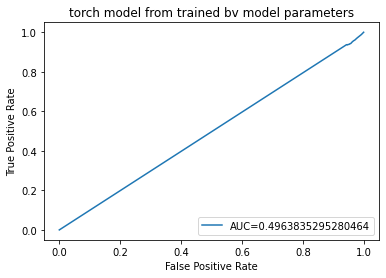

In [ ]:
"""
Do the same bv model to hls4ml conversion. but also ap_fixed quantize the batchnorm 
"""
import hls4ml 
from sklearn.metrics import mean_squared_error


int_bit = target_int_bitwidth 
fract_bit = target_fract_bitwidth
total_bit = int_bit + fract_bit
ap_fixed_config = f"ap_fixed<{total_bit},{int_bit}>"
print(f"cut_down_model: {torch_model[1:]}")
config = hls4ml.utils.config_from_pytorch_model(
                                    torch_model,
                                    default_precision=ap_fixed_config,
                                    granularity='model'
)
print(f"config: {config}")
hls_model = hls4ml.converters.convert_from_pytorch_model(
                                                    torch_model,
                                                    hls_config=config,
                                                    output_dir='model_1/hls4ml_prj',
                                                    part='xcu250-figd2104-2L-e',
                                                    input_shape = (100,30) # 100 here is irrelevant
)
hls_model.compile()
torch_model.eval()
with torch.no_grad():
  print(f"X_test b4: {X_test.shape}")
  X_hls_test = np.ascontiguousarray(X_test)
  Y_hat_hls = torch.sigmoid(torch.from_numpy(hls_model.predict(X_hls_test)))

torch_model.eval()
model_bv_seq.eval()
with torch.no_grad():
  Y_hat_bv = torch.sigmoid(model_bv_seq(X_test))
  Y_hat_torch = torch.sigmoid(torch_model(X_test))
MSE = mean_squared_error(Y_hat_bv.cpu().numpy(), Y_hat_hls.cpu().numpy())
print(f"MSE bv vs hls test output: {MSE}")
MSE = mean_squared_error(Y_hat_torch.cpu().numpy(), Y_hat_hls.cpu().numpy())
print(f"MSE loaded torch model vs hls test output: {MSE}")

fpr, tpr, _ = metrics.roc_curve(Y_test,  Y_hat_hls.cpu().numpy())
auc = metrics.roc_auc_score(Y_test, Y_hat_hls.cpu().numpy())
  

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("torch model from trained bv model parameters")
plt.legend(loc=4)
plt.show()

Very low performance after quantizing the batchnorm is expected. Batchnorm is known to be sensitive to quantization (ie need higher bitwidth)

#Now try qnn batchnorm1d

In [ ]:
"""
debugging BatchNorm1dToQuantScaleBias
"""
from typing import Union, Type, Optional

import torch
from torch import Tensor
from torch.nn import Module, Parameter

from brevitas.function.ops_ste import ceil_ste
from brevitas.function.ops import max_int
from brevitas.quant_tensor import QuantTensor
from brevitas.inject.defaults import Int8WeightPerTensorFloat
from brevitas.nn.quant_layer import QuantWeightBiasInputOutputLayer as QuantWBIOL
from brevitas.nn.quant_layer import WeightQuantType, BiasQuantType, ActQuantType


class ScaleBias(Module):

    def __init__(self, num_features: int, bias: bool, runtime_shape=(1, -1, 1, 1)):
        super(ScaleBias, self).__init__()
        self.num_features = num_features
        self.weight = Parameter(torch.ones(num_features))
        self.bias = Parameter(torch.zeros(num_features)) if bias else None
        self.runtime_shape = runtime_shape
        print(f"ScaleBias runtime_shape: {runtime_shape}")
        print(f"ScaleBias weight shape: {self.weight.shape}")
        print(f"ScaleBias bias shape: {self.bias.shape}")
        print(f"self.weight.view(self.runtime_shape) shape: {self.weight.view(self.runtime_shape).shape}")
        print(f"self.bias.view(self.runtime_shape) shape: {self.bias.view(self.runtime_shape).shape}")

    def forward(self, input):
        output = input * self.weight.view(self.runtime_shape) + self.bias.view(self.runtime_shape)
        # print(f"ScaleBias output shape: {output.shape}")
        return output


class QuantScaleBias(QuantWBIOL, ScaleBias):

    def __init__(
            self,
            num_features: int,
            bias: bool,
            runtime_shape=(1, -1, 1, 1),
            weight_quant: Optional[WeightQuantType] = Int8WeightPerTensorFloat,
            bias_quant: Optional[BiasQuantType] = None,
            input_quant: Optional[ActQuantType] = None,
            output_quant: Optional[ActQuantType] = None,
            return_quant_tensor: bool = False,
            **kwargs) -> None:
        ScaleBias.__init__(self, num_features, bias, runtime_shape=runtime_shape)
        QuantWBIOL.__init__(
            self,
            weight_quant=weight_quant,
            bias_quant=bias_quant,
            input_quant=input_quant,
            output_quant=output_quant,
            return_quant_tensor=return_quant_tensor,
            **kwargs)
        print(f"QuantScaleBias weight_quant bit_width: {weight_quant.bit_width}")
        print(f"QuantScaleBias bias_quant bit_width: {bias_quant.bit_width}")

    @property
    def per_elem_ops(self):
        return 2

    @property
    def output_channel_dim(self):
        return 0

    @property
    def out_channels(self):
        return self.num_features

    @property
    def channelwise_separable(self) -> bool:
        return True

    def quant_weight(self):
        return self.weight_quant(self.weight.view(-1, 1))  # TODO check if the view is needed

    def forward(self, inp: Union[Tensor, QuantTensor]) -> Union[Tensor, QuantTensor]:
        # print("forward")
        return self.forward_impl(inp)

    def inner_forward_impl(self, input: Tensor, quant_weight: Tensor, quant_bias: Optional[Tensor]):
        # print(f"self.runtime_shape: {self.runtime_shape}")
        quant_weight = quant_weight.view(self.runtime_shape)
        # print(f"quant_weight shape: {quant_weight.shape}")
        quant_bias = quant_bias.view(self.runtime_shape)
        # print(f"quant_bias shape: {quant_bias.shape}")
        output_tensor = input * quant_weight + quant_bias
        # print(f"output_tensor shape: {output_tensor.shape}")
        return output_tensor

    def max_acc_bit_width(self, input_bit_width, weight_bit_width):
        max_input_val = max_int(bit_width=input_bit_width, signed=False, narrow_range=False)
        max_weight_val = self.weight_quant.max_uint_value(weight_bit_width)
        max_output_val = max_input_val * max_weight_val
        output_bit_width = ceil_ste(torch.log2(max_output_val))
        return output_bit_width

In [ ]:
from abc import ABC
from typing import Optional

import brevitas.config as config
from brevitas.inject.defaults import Int8WeightPerTensorFloat
from brevitas.nn.utils import mul_add_from_bn
from brevitas.nn.quant_layer import WeightQuantType, BiasQuantType, ActQuantType

class _BatchNormToQuantScaleBias(QuantScaleBias, ABC):

    def _load_from_state_dict(self, state_dict, prefix, local_metadata, strict,
                              missing_keys, unexpected_keys, error_msgs):
        weight_key = prefix + 'weight'
        bias_key = prefix + 'bias'
        running_mean_key = prefix + 'running_mean'
        running_var_key = prefix + 'running_var'
        num_batches_tracked_key = prefix + 'num_batches_tracked'
        if running_mean_key in state_dict and running_var_key in state_dict:
            weight_init, bias_init = mul_add_from_bn(
                bn_bias=state_dict[bias_key],
                bn_weight=state_dict[weight_key],
                bn_mean=state_dict[running_mean_key],
                bn_var=state_dict[running_var_key],
                bn_eps=self.eps)
            self.weight.data = weight_init
            self.bias.data = bias_init
            del state_dict[bias_key]
            del state_dict[weight_key]
            del state_dict[running_mean_key]
            del state_dict[running_var_key]
            del state_dict[num_batches_tracked_key]
        super(_BatchNormToQuantScaleBias, self)._load_from_state_dict(
            state_dict, prefix, local_metadata, strict, missing_keys, unexpected_keys, error_msgs)
        if config.IGNORE_MISSING_KEYS and bias_key in missing_keys:
            missing_keys.remove(bias_key)
        if config.IGNORE_MISSING_KEYS and weight_key in missing_keys:
            missing_keys.remove(weight_key)
        if num_batches_tracked_key in unexpected_keys:
            unexpected_keys.remove(num_batches_tracked_key)


class BatchNorm1dToQuantScaleBias(_BatchNormToQuantScaleBias):

    def __init__(
            self,
            num_features,
            eps: float = 1e-5,
            weight_quant: Optional[WeightQuantType] = Int8WeightPerTensorFloat,
            bias_quant: Optional[BiasQuantType] = None,
            input_quant: Optional[ActQuantType] = None,
            output_quant: Optional[ActQuantType] = None,
            return_quant_tensor: bool = False,
            **kwargs):
        super(BatchNorm1dToQuantScaleBias, self).__init__(
            num_features,
            bias=True,
            # runtime_shape=(1, -1, 1),
            runtime_shape=(1, -1),
            weight_quant=weight_quant,
            bias_quant=bias_quant,
            input_quant=input_quant,
            output_quant=output_quant,
            return_quant_tensor=return_quant_tensor,
            **kwargs)
        self.eps = eps

In [ ]:
"""
playing around with different parameters 
"""
target_int_bitwidth = 5
target_fract_bitwidth = 6

target_bitwidth, target_scale_factor, target_zero_point = ConvAp_FixedToUAQ(target_int_bitwidth, target_fract_bitwidth)



In [ ]:
"""
Reinitialize the custom quantizers again...
"""

custom_bit_width = target_bitwidth
custom_scale = target_scale_factor
custom_scaling_impl = custom_scale*2**(custom_bit_width-1)

class PerTensorActPoTScalingCustombit(ExtendedInjector):
    """
    """
    scaling_per_output_channel = False
    restrict_scaling_type = RestrictValueType.POWER_OF_TWO
    bit_width = custom_bit_width
    restrict_value_float_to_int_impl = CeilSte

class PerTensorWeightPoTScalingCustombit(ExtendedInjector):
    """
    """
    scaling_per_output_channel = False
    restrict_scaling_type = RestrictValueType.POWER_OF_TWO
    bit_width = custom_bit_width
    restrict_value_float_to_int_impl = CeilSte
    scaling_impl = ConstScaling(custom_scaling_impl)

class CustomMaxScaling(ExtendedInjector):
    """
    """
    scaling_impl_type = ScalingImplType.CONST
    scaling_stats_op = StatsOp.MAX

class ParamFromRuntimePercentileScaling(ExtendedInjector):
    """
    """
    scaling_impl_type = ScalingImplType.CONST
    scaling_stats_op = StatsOp.PERCENTILE
    percentile_q = 99.999
    collect_stats_steps = 300

class IntCustomWeightPerTensorFixedPoint(
    NarrowIntQuant, CustomMaxScaling, PerTensorWeightPoTScalingCustombit, WeightQuantSolver):
    """
    8-bit narrow per-tensor signed fixed-point weight quantizer with the radix point
    computed from backpropagated statistics of the weight tensor.

    Examples:
        >>> from brevitas.nn import QuantLinear
        >>> fc = QuantLinear(10, 5, bias=False, weight_quant=Int8WeightPerTensorFixedPoint)
        >>> fc.quant_weight()
    """
    pass


class IntCustomActPerTensorFixedPoint(
    IntQuant, ParamFromRuntimePercentileScaling, PerTensorActPoTScalingCustombit, ActQuantSolver):
    """
    8-bit per-tensor signed int activations fixed-point quantizer with learned radix point
    initialized from runtime statistics.

    Examples:
        >>> from brevitas.nn import QuantIdentity
        >>> act = QuantIdentity(act_quant=Int8ActPerTensorFixedPoint)
    """
    min_val = -custom_scale*2**(custom_bit_width-1)
    max_val = custom_scale*(2**(custom_bit_width-1)-1)
    print(f"min_val: {min_val}")
    print(f"max_val: {max_val}")

# class UintCustomActPerTensorFixedPoint(
#     UintQuant, ParamFromRuntimePercentileScaling, PerTensorActPoTScalingCustombit, ActQuantSolver):
#     """
#     8-bit per-tensor unsigned int activations fixed-point quantizer with learned radix point
#     initialized from runtime statistics.

#     Examples:
#         >>> from brevitas.nn import QuantReLU
#         >>> act = QuantReLU(act_quant=Uint8ActPerTensorFixedPoint)
#     """
#     pass


class IntCustomBiasPerTensorFixedPointInternalScaling(
    IntQuant, MaxStatsScaling, PerTensorWeightPoTScalingCustombit, BiasQuantSolver):
    """
    8-bit per-tensor signed fixed-point bias quantizer with the radix point computed
    from backpropagated statistics of the bias tensor.

    Examples:
        >>> from brevitas.nn import QuantLinear
        >>> fc = QuantLinear(10, 5, bias=True, bias_quant=Int8BiasPerTensorFixedPointInternalScaling)
    """
    requires_input_scale = False
    requires_input_bit_width = False

min_val: -16.0
max_val: 15.984375


In [ ]:
bn_target_int_bitwidth = 8
bn_target_fract_bitwidth = 12

bn_target_bitwidth, bn_target_scale_factor, bn_target_zero_point = ConvAp_FixedToUAQ(bn_target_int_bitwidth, bn_target_fract_bitwidth)

In [ ]:
"""
Reinitialize the custom quantizers for quantized batchnorm seperately
"""

custom_bit_width = bn_target_bitwidth
custom_scale = bn_target_scale_factor
print(f"scale: {custom_scale}")

custom_scaling_impl = custom_scale*2**(custom_bit_width-1)

class PerTensorActPoTScalingCustombit(ExtendedInjector):
    """
    """
    scaling_per_output_channel = False
    restrict_scaling_type = RestrictValueType.POWER_OF_TWO
    bit_width = custom_bit_width
    restrict_value_float_to_int_impl = CeilSte

class PerTensorWeightPoTScalingCustombit(ExtendedInjector):
    """
    """
    scaling_per_output_channel = False
    restrict_scaling_type = RestrictValueType.POWER_OF_TWO
    bit_width = custom_bit_width
    restrict_value_float_to_int_impl = CeilSte
    scaling_impl = ConstScaling(custom_scaling_impl)

class CustomMaxScaling(ExtendedInjector):
    """
    """
    scaling_impl_type = ScalingImplType.CONST
    scaling_stats_op = StatsOp.MAX

class ParamFromRuntimePercentileScaling(ExtendedInjector):
    """
    """
    scaling_impl_type = ScalingImplType.CONST
    scaling_stats_op = StatsOp.PERCENTILE
    percentile_q = 99.999
    collect_stats_steps = 300

class BnIntCustomWeightPerTensorFixedPoint(
    NarrowIntQuant, CustomMaxScaling, PerTensorWeightPoTScalingCustombit, WeightQuantSolver):
    """
    8-bit narrow per-tensor signed fixed-point weight quantizer with the radix point
    computed from backpropagated statistics of the weight tensor.

    Examples:
        >>> from brevitas.nn import QuantLinear
        >>> fc = QuantLinear(10, 5, bias=False, weight_quant=Int8WeightPerTensorFixedPoint)
        >>> fc.quant_weight()
    """
    pass


class BnIntCustomActPerTensorFixedPoint(
    IntQuant, ParamFromRuntimePercentileScaling, PerTensorActPoTScalingCustombit, ActQuantSolver):
    """
    8-bit per-tensor signed int activations fixed-point quantizer with learned radix point
    initialized from runtime statistics.

    Examples:
        >>> from brevitas.nn import QuantIdentity
        >>> act = QuantIdentity(act_quant=Int8ActPerTensorFixedPoint)
    """
    min_val = -custom_scale*2**(custom_bit_width-1)
    max_val = custom_scale*(2**(custom_bit_width-1)-1)
    print(f"min_val: {min_val}")
    print(f"max_val: {max_val}")


class BnIntCustomBiasPerTensorFixedPointInternalScaling(
    IntQuant, MaxStatsScaling, PerTensorWeightPoTScalingCustombit, BiasQuantSolver):
    """
    8-bit per-tensor signed fixed-point bias quantizer with the radix point computed
    from backpropagated statistics of the bias tensor.

    Examples:
        >>> from brevitas.nn import QuantLinear
        >>> fc = QuantLinear(10, 5, bias=True, bias_quant=Int8BiasPerTensorFixedPointInternalScaling)
    """
    requires_input_scale = False
    requires_input_bit_width = False

scale: 0.000244140625
min_val: -128.0
max_val: 127.999755859375


In [ ]:
import brevitas.nn as qnn
from brevitas.core.quant import QuantType
from brevitas.quant.scaled_int import Int8ActPerTensorFloat, Int8WeightPerTensorFloat
from brevitas.quant.shifted_scaled_int import ShiftedUint8ActPerTensorFloat
import brevitas.quant.fixed_point as fp
"""
NOTE: try quantizing the input data and 
see if there's big changes
"""

input_dim = 30
# mlp_dims = [30 , 64, 32, 32]
mlp_dims = [30 , 16, 8, 8]
# mlp_dims = [30 , 128, 64, 64]
mlp_blocks = []
quant_batchnorm = BatchNorm1dToQuantScaleBias(
                  num_features=input_dim,
                  weight_quant=BnIntCustomWeightPerTensorFixedPoint,
                  bias_quant=BnIntCustomBiasPerTensorFixedPointInternalScaling,
                  input_quant= BnIntCustomActPerTensorFixedPoint,
                  output_quant= BnIntCustomActPerTensorFixedPoint,
                  return_quant_tensor=True
)  
# quant_batchnorm.runtime_shape = (1,30)

mlp_blocks.append(quant_batchnorm)

for idx in range(len(mlp_dims)-1):
  # print(mlp_dims[idx + 1])
  if idx ==0:
    q_linear = qnn.QuantLinear(
                  int(mlp_dims[idx]), 
                  int(mlp_dims[idx + 1]),
                  bias=True,
                  weight_quant=BnIntCustomWeightPerTensorFixedPoint,
                  bias_quant=BnIntCustomBiasPerTensorFixedPointInternalScaling,
                  input_quant= BnIntCustomActPerTensorFixedPoint,
                  output_quant= BnIntCustomActPerTensorFixedPoint,
                  return_quant_tensor=True
    )  
  else:
    q_linear = qnn.QuantLinear(
                    int(mlp_dims[idx]), 
                    int(mlp_dims[idx + 1]),
                    bias=True,
                    weight_quant=IntCustomWeightPerTensorFixedPoint,
                    bias_quant=IntCustomBiasPerTensorFixedPointInternalScaling,
                    input_quant= IntCustomActPerTensorFixedPoint,
                    output_quant= IntCustomActPerTensorFixedPoint,
                    return_quant_tensor=True
    )  
  # q_linear = qnn.QuantLinear(
  #                   int(mlp_dims[idx]), 
  #                   int(mlp_dims[idx + 1]),
  #                   bias=True,
  #                   weight_quant=IntCustomWeightPerTensorFixedPoint,
  #                   bias_quant=IntCustomBiasPerTensorFixedPointInternalScaling,
  #                   input_quant= IntCustomActPerTensorFixedPoint,
  #                   output_quant= IntCustomActPerTensorFixedPoint,
  #                   return_quant_tensor=True
  # )
  print(f"q_linear.weight_quant.bit_width: {q_linear.quant_weight().bit_width}")
  mlp_blocks.append(q_linear)
  
  mlp_blocks.append(
      qnn.QuantReLU(
          act_quant=IntCustomActPerTensorFixedPoint,
          return_quant_tensor=True
      )
  )
# add last layer
mlp_blocks.append(qnn.QuantLinear(
                  mlp_dims[len(mlp_dims)-1], 
                  1,
                  bias=True,
                  weight_quant=IntCustomWeightPerTensorFixedPoint,
                  bias_quant=IntCustomBiasPerTensorFixedPointInternalScaling,
                  input_quant= IntCustomActPerTensorFixedPoint,
                  output_quant= IntCustomActPerTensorFixedPoint,
                  return_quant_tensor=True
                  )
)
mlp_blocks.append(
      qnn.QuantSigmoid(
          act_quant=IntCustomActPerTensorFixedPoint,
          return_quant_tensor=True
      )
)
model_bv_seq = nn.Sequential(*mlp_blocks)



ScaleBias runtime_shape: (1, -1)
ScaleBias weight shape: torch.Size([30])
ScaleBias bias shape: torch.Size([30])
self.weight.view(self.runtime_shape) shape: torch.Size([1, 30])
self.bias.view(self.runtime_shape) shape: torch.Size([1, 30])
QuantScaleBias weight_quant bit_width: 20
QuantScaleBias bias_quant bit_width: 20
q_linear.weight_quant.bit_width: 20.0
q_linear.weight_quant.bit_width: 11.0
q_linear.weight_quant.bit_width: 11.0


In [ ]:
"""
Training phase
"""
import torch.nn.functional as F

model_bv_seq.train() # put model in train mode (for batchnormalization)
optimizer = torch.optim.AdamW(model_bv_seq.parameters(), lr=1e-3)
i = 0
for x, y in train_dataloader:
  # print(x.shape)
  # print(model_bv_seq[0](x).shape)
  # print(model_bv_seq(x).shape)
  # print(model_bv_seq[0].runtime_shape)
  loss = F.binary_cross_entropy(model_bv_seq(x), y)
  i +=1
  # if i > 100:
  #   break

  optimizer.zero_grad() # this deletes all previous grad calculations. very important
  loss.backward() # calculates the gradients
  optimizer.step() # applies backpropagation
  

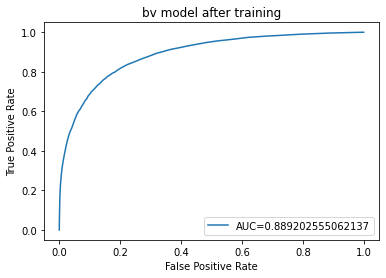

In [ ]:
"""
Testing phase
"""
from sklearn import metrics
import matplotlib.pyplot as plt

model_bv_seq.eval() # put model in eval mode 
with torch.no_grad():
  Y_hat = model_bv_seq(X_test)[0]
  fpr, tpr, _ = metrics.roc_curve(Y_test,  Y_hat)
  auc = metrics.roc_auc_score(Y_test, Y_hat)
  

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("bv model after training")
plt.legend(loc=4)
plt.show()


In [ ]:
input_dim = 30
batch_dim = 64
x = torch.rand(64,30)
quant_batchnorm = qnn.BatchNorm1dToQuantScaleBias(
                  num_features=input_dim,
                  return_quant_tensor=True
)  
print(quant_batchnorm(x).shape)

torch.Size([1, 30, 64, 30])


##Extra: Post Training Quatization (PTQ) 
(currently under works)

In [ ]:
"""
Now doing Post Training Quantization with hls4ml to compare performance
Parameter search over integer bits. Fractional bits frozen at 20    
"""


print(hls4ml.__version__)

fract_bit = 14
aurocs_int_q = []
ap_fixed_configs_int = []

for int_bit in range(2,13,1): 
    total_bit = int_bit + fract_bit
    ap_fixed_config = f"ap_fixed<{total_bit},{int_bit}>"
    config = hls4ml.utils.config_from_pytorch_model(torch_model,
                                        default_precision=ap_fixed_config,
                                        granularity='model'
    )
    print(f"config: {config}")
    hls_model = hls4ml.converters.convert_from_pytorch_model(torch_model,
                                                        hls_config=config,
                                                        output_dir='model_1/hls4ml_prj',
                                                        part='xcu250-figd2104-2L-e',
                                                        input_shape = (100,30) # 100 here is irrelevant
    )
    hls_model.compile()
    X_hls_test = np.ascontiguousarray(X_test)
    Y_hat = torch.sigmoid(torch.from_numpy(hls_model.predict(X_hls_test)))
    auc = metrics.roc_auc_score(Y_test, Y_hat.cpu().numpy())
    aurocs_int_q.append(auc)
    # ap_fixed_configs_int.append(f"<{total_bit},{int_bit}>")
    ap_fixed_configs_int.append(int_bit)
    

0.6.0
config: {'Model': {'Precision': 'ap_fixed<16,2>', 'ReuseFactor': 1, 'Strategy': 'Latency'}}
Interpreting Model ...
Topology:
Input Shape:  [[100, 30]]
Layer name: 0, layer type: BatchNormalization, input shape: [[100, 30]]
Layer name: 1, layer type: Dense, input shape: [[100, 30]]
Layer name: 2, layer type: Activation, input shape: [[100, 16]]
Layer name: 3, layer type: Dense, input shape: [[100, 16]]
Layer name: 4, layer type: Activation, input shape: [[100, 8]]
Layer name: 5, layer type: Dense, input shape: [[100, 8]]
Layer name: 6, layer type: Activation, input shape: [[100, 8]]
Layer name: 7, layer type: Dense, input shape: [[100, 8]]
Creating HLS model
Writing HLS project
Done
config: {'Model': {'Precision': 'ap_fixed<17,3>', 'ReuseFactor': 1, 'Strategy': 'Latency'}}
Interpreting Model ...
Topology:
Input Shape:  [[100, 30]]
Layer name: 0, layer type: BatchNormalization, input shape: [[100, 30]]
Layer name: 1, layer type: Dense, input shape: [[100, 30]]
Layer name: 2, layer 

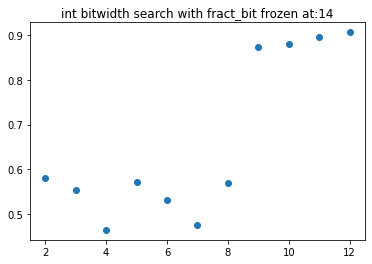

In [ ]:
plt.scatter(ap_fixed_configs_int, aurocs_int_q)
plt.title(f"int bitwidth search with fract_bit frozen at:{fract_bit}")
plt.show()

In [ ]:
"""
Parameter search over fractional bits. Integer bits frozen at 11   
"""
int_bit = 11
aurocs_fract_q = []
ap_fixed_configs_fract = []

for fract_bit in range(2,32,2):
    total_bit = int_bit + fract_bit
    ap_fixed_config = f"ap_fixed<{total_bit},{int_bit}>"
    config = hls4ml.utils.config_from_pytorch_model(torch_model,
                                        default_precision=ap_fixed_config,
                                        granularity='model'
    )
    print(f"config: {config}")
    hls_model = hls4ml.converters.convert_from_pytorch_model(torch_model,
                                                        hls_config=config,
                                                        output_dir='model_1/hls4ml_prj',
                                                        part='xcu250-figd2104-2L-e',
                                                        input_shape = (100,30) # 100 here is irrelevant
    )
    hls_model.compile()
    X_hls_test = np.ascontiguousarray(X_test)
    auc = metrics.roc_auc_score(Y_test, hls_model.predict(X_hls_test))
    aurocs_fract_q.append(auc)
    # ap_fixed_configs_fract.append(f"<{total_bit},{int_bit}>")
    ap_fixed_configs_fract.append(fract_bit)
    


config: {'Model': {'Precision': 'ap_fixed<13,11>', 'ReuseFactor': 1, 'Strategy': 'Latency'}}
Interpreting Model ...
Topology:
Input Shape:  [[100, 30]]
Layer name: 0, layer type: BatchNormalization, input shape: [[100, 30]]
Layer name: 1, layer type: Dense, input shape: [[100, 30]]
Layer name: 2, layer type: Activation, input shape: [[100, 16]]
Layer name: 3, layer type: Dense, input shape: [[100, 16]]
Layer name: 4, layer type: Activation, input shape: [[100, 8]]
Layer name: 5, layer type: Dense, input shape: [[100, 8]]
Layer name: 6, layer type: Activation, input shape: [[100, 8]]
Layer name: 7, layer type: Dense, input shape: [[100, 8]]
Creating HLS model
Writing HLS project
Done
config: {'Model': {'Precision': 'ap_fixed<15,11>', 'ReuseFactor': 1, 'Strategy': 'Latency'}}
Interpreting Model ...
Topology:
Input Shape:  [[100, 30]]
Layer name: 0, layer type: BatchNormalization, input shape: [[100, 30]]
Layer name: 1, layer type: Dense, input shape: [[100, 30]]
Layer name: 2, layer type

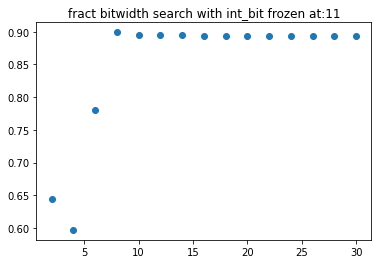

In [ ]:
plt.scatter(ap_fixed_configs_fract, aurocs_fract_q)
plt.title(f"fract bitwidth search with int_bit frozen at:{int_bit}")
plt.show()

In [ ]:
"""
Start normal model and train it normally for comparison of PTQ
"""
input_dim = 30
weight_precision = 8 # 8
# mlp_dims = [30 , 64, 32, 32]
mlp_dims = [30 , 16, 8, 8]
mlp_blocks = [nn.BatchNorm1d(input_dim)]
for idx in range(len(mlp_dims)-1):
  # print(mlp_dims[idx + 1])
  mlp_blocks.append(nn.Linear(
                  int(mlp_dims[idx]), 
                  int(mlp_dims[idx + 1]),
                  bias=True
                  )
                  
  )
  mlp_blocks.append(
      nn.ReLU()
  )
# add last layer
mlp_blocks.append(nn.Linear(
                  mlp_dims[len(mlp_dims)-1], 
                  1,
                  bias=True,
                  )
  )

normal_model = nn.Sequential(*mlp_blocks)


In [ ]:
"""
Training phase
NOTE: no sigmoid in the model itself
"""
import torch.nn.functional as F

normal_model.train() # put model in train mode (for batchnormalization)
optimizer = torch.optim.AdamW(normal_model.parameters(), lr=1e-3)
i = 0
for x, y in train_dataloader:
  # print(y.shape)
  # print(normal_model(x).shape)
  logit = normal_model(x)
  loss = F.binary_cross_entropy(torch.sigmoid(logit), y)
  i +=1
  # if i > 100:
  #   break

  optimizer.zero_grad() # this deletes all previous grad calculations. very important
  loss.backward() # calculates the gradients
  optimizer.step() # applies backpropagation
  

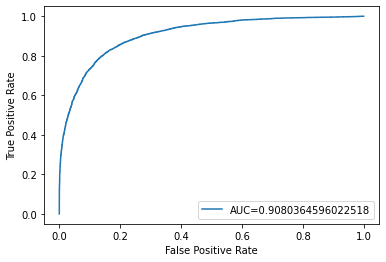

In [ ]:
"""
Testing phase
"""


normal_model.eval() # put model in eval mode 
with torch.no_grad():
  logit = normal_model(X_test)
  fpr, tpr, _ = metrics.roc_curve(Y_test,  torch.sigmoid(logit))
  auc = metrics.roc_auc_score(Y_test, torch.sigmoid(logit))
  

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

config: {'Model': {'Precision': 'ap_fixed<34,14>', 'ReuseFactor': 1, 'Strategy': 'Latency'}}
Interpreting Model ...
Topology:
Input Shape:  [[100, 30]]
Layer name: 0, layer type: BatchNormalization, input shape: [[100, 30]]
Layer name: 1, layer type: Dense, input shape: [[100, 30]]
Layer name: 2, layer type: Activation, input shape: [[100, 16]]
Layer name: 3, layer type: Dense, input shape: [[100, 16]]
Layer name: 4, layer type: Activation, input shape: [[100, 8]]
Layer name: 5, layer type: Dense, input shape: [[100, 8]]
Layer name: 6, layer type: Activation, input shape: [[100, 8]]
Layer name: 7, layer type: Dense, input shape: [[100, 8]]
Creating HLS model
Writing HLS project
Done
MSE torch vs hls test output: 1.5880913251109519e-10


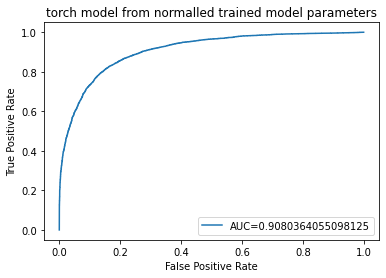

In [ ]:
"""
check if torch hls conversion is good for normal model
"""
import hls4ml 
from sklearn.metrics import mean_squared_error

int_bit = 14 #14
fract_bit = 20 #20
total_bit = int_bit + fract_bit
ap_fixed_config = f"ap_fixed<{total_bit},{int_bit}>"
config = hls4ml.utils.config_from_pytorch_model(normal_model,
                                    default_precision=ap_fixed_config,
                                    granularity='model'
)
print(f"config: {config}")
hls_model = hls4ml.converters.convert_from_pytorch_model(normal_model,
                                                    hls_config=config,
                                                    output_dir='model_1/hls4ml_prj',
                                                    part='xcu250-figd2104-2L-e',
                                                    input_shape = (100,30) # 100 here is irrelevant
)
hls_model.compile()
X_hls_test = np.ascontiguousarray(X_test)
Y_hat_hls = torch.sigmoid(torch.from_numpy(hls_model.predict(X_hls_test)))

normal_model.eval()
with torch.no_grad():
  Y_hat_torch = torch.sigmoid(normal_model(X_test))
MSE = mean_squared_error(Y_hat_torch.cpu().numpy(), Y_hat_hls.cpu().numpy())
print(f"MSE torch vs hls test output: {MSE}")


fpr, tpr, _ = metrics.roc_curve(Y_test,  Y_hat_hls.cpu().numpy())
auc = metrics.roc_auc_score(Y_test, Y_hat_hls.cpu().numpy())
  

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("torch model from normalled trained model parameters")
plt.legend(loc=4)
plt.show()

In [ ]:
"""
PTQ with normal model
Parameter search over integer bits. Fractional bits frozen at 20    
"""
import hls4ml 

print(hls4ml.__version__)

fract_bit = 20
aurocs_int = []
ap_fixed_configs_int = []

for int_bit in range(8,15,1): # search from 2 to 32, with with 4 bit intervals
    total_bit = int_bit + fract_bit
    ap_fixed_config = f"ap_fixed<{total_bit},{int_bit}>"
    config = hls4ml.utils.config_from_pytorch_model(normal_model,
                                        default_precision=ap_fixed_config,
                                        granularity='model'
    )
    print(f"config: {config}")
    hls_model = hls4ml.converters.convert_from_pytorch_model(normal_model,
                                                        hls_config=config,
                                                        output_dir='model_1/hls4ml_prj',
                                                        part='xcu250-figd2104-2L-e',
                                                        input_shape = (100,30) # 100 here is irrelevant
    )
    hls_model.compile()
    X_hls_test = np.ascontiguousarray(X_test)
    Y_hat = torch.sigmoid(torch.from_numpy(hls_model.predict(X_hls_test)))
    auc = metrics.roc_auc_score(Y_test, Y_hat.cpu().numpy())
    aurocs_int.append(auc)
    ap_fixed_configs_int.append(f"<{total_bit},{int_bit}>")
    

0.6.0
config: {'Model': {'Precision': 'ap_fixed<28,8>', 'ReuseFactor': 1, 'Strategy': 'Latency'}}
Interpreting Model ...
Topology:
Input Shape:  [[100, 30]]
Layer name: 0, layer type: BatchNormalization, input shape: [[100, 30]]
Layer name: 1, layer type: Dense, input shape: [[100, 30]]
Layer name: 2, layer type: Activation, input shape: [[100, 16]]
Layer name: 3, layer type: Dense, input shape: [[100, 16]]
Layer name: 4, layer type: Activation, input shape: [[100, 8]]
Layer name: 5, layer type: Dense, input shape: [[100, 8]]
Layer name: 6, layer type: Activation, input shape: [[100, 8]]
Layer name: 7, layer type: Dense, input shape: [[100, 8]]
Creating HLS model
Writing HLS project
Done
config: {'Model': {'Precision': 'ap_fixed<29,9>', 'ReuseFactor': 1, 'Strategy': 'Latency'}}
Interpreting Model ...
Topology:
Input Shape:  [[100, 30]]
Layer name: 0, layer type: BatchNormalization, input shape: [[100, 30]]
Layer name: 1, layer type: Dense, input shape: [[100, 30]]
Layer name: 2, layer 

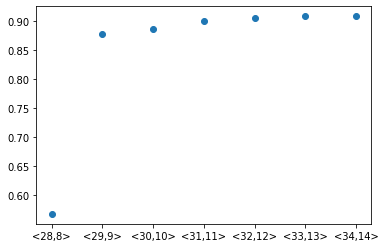

In [ ]:
plt.scatter(ap_fixed_configs_int, aurocs_int)

In [ ]:
"""
Parameter search over fractional bits. Integer bits frozen at 13    
"""
int_bit = 13
aurocs_fract = []
ap_fixed_configs_fract = []

for fract_bit in range(6,13,1):
    total_bit = int_bit + fract_bit
    ap_fixed_config = f"ap_fixed<{total_bit},{int_bit}>"
    config = hls4ml.utils.config_from_pytorch_model(normal_model,
                                        default_precision=ap_fixed_config,
                                        granularity='model'
    )
    print(f"config: {config}")
    hls_model = hls4ml.converters.convert_from_pytorch_model(normal_model,
                                                        hls_config=config,
                                                        output_dir='model_1/hls4ml_prj',
                                                        part='xcu250-figd2104-2L-e',
                                                        input_shape = (100,30) # 100 here is irrelevant
    )
    hls_model.compile()
    X_hls_test = np.ascontiguousarray(X_test)
    auc = metrics.roc_auc_score(Y_test, hls_model.predict(X_hls_test))
    aurocs_fract.append(auc)
    ap_fixed_configs_fract.append(f"<{total_bit},{int_bit}>")


config: {'Model': {'Precision': 'ap_fixed<19,13>', 'ReuseFactor': 1, 'Strategy': 'Latency'}}
Interpreting Model ...
Topology:
Input Shape:  [[100, 30]]
Layer name: 0, layer type: BatchNormalization, input shape: [[100, 30]]
Layer name: 1, layer type: Dense, input shape: [[100, 30]]
Layer name: 2, layer type: Activation, input shape: [[100, 16]]
Layer name: 3, layer type: Dense, input shape: [[100, 16]]
Layer name: 4, layer type: Activation, input shape: [[100, 8]]
Layer name: 5, layer type: Dense, input shape: [[100, 8]]
Layer name: 6, layer type: Activation, input shape: [[100, 8]]
Layer name: 7, layer type: Dense, input shape: [[100, 8]]
Creating HLS model
Writing HLS project
Done
config: {'Model': {'Precision': 'ap_fixed<20,13>', 'ReuseFactor': 1, 'Strategy': 'Latency'}}
Interpreting Model ...
Topology:
Input Shape:  [[100, 30]]
Layer name: 0, layer type: BatchNormalization, input shape: [[100, 30]]
Layer name: 1, layer type: Dense, input shape: [[100, 30]]
Layer name: 2, layer type

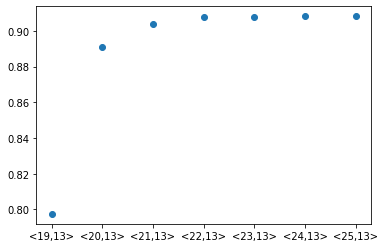

In [ ]:
plt.scatter(ap_fixed_configs_fract, aurocs_fract)

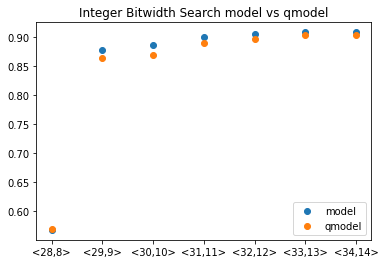

In [ ]:
plt.scatter(ap_fixed_configs_int, aurocs_int, label="model")
plt.scatter(ap_fixed_configs_int, aurocs_int_q, label="qmodel")
plt.legend()
plt.title("Integer Bitwidth Search model vs qmodel")
plt.show()

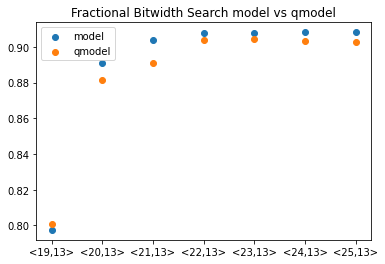

In [ ]:
plt.scatter(ap_fixed_configs_fract, aurocs_fract, label="model")
plt.scatter(ap_fixed_configs_fract, aurocs_fract_q, label="qmodel")
plt.legend()
plt.title("Fractional Bitwidth Search model vs qmodel")
plt.show()